#Прогин круглої пластинки.

$\cfrac{1}{r}\cfrac{d}{dr} \left( r\cfrac{d}{dr} \left( \cfrac{1}{r} \cfrac{d}{dr} \left( r \cfrac{dw}{dr} \right) \right) \right) = \cfrac{q}{D}$

Або

$\cfrac{d^4w}{dr^4}+\cfrac{2}{r}\cfrac{d^3w}{dr^3}-\cfrac{1}{r^2}\cfrac{d^2w}{dr^2}+\cfrac{1}{r^3}\cfrac{dw}{dr}=\cfrac{q}{D}$

##Вільне опирання по контуру

Граничні умови

$w(a)=0,$

$M_r(a)=0.$

Причому

$M_r = -D \left( \cfrac{d^2w}{dr^2}+\cfrac{\nu}{r}\cfrac{dw}{dr} \right)$

Розв'язок

$w=\cfrac{q(a^2-r^2)}{64D} \left( \cfrac{5+\nu}{1+\nu}a^2-r^2 \right)$

$w_{max}=\cfrac{qa^4(5+\nu)}{64(1+\nu)D}$


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D


In [ ]:
a = 0.4
q = 0.1
G = 2.77 * 10**4
nu = 0.3
E = 2*G*(1+nu)
h = 18*10**(-3)
D = E*h**3/(12*(1-nu**2))
print(E)
print(D)

72020.0
0.03846342857142858


In [ ]:
def w(r, D, nu):
    return q*(a**2-r**2)/(64*D)*((5+nu)/(1+nu)*a**2-r**2)

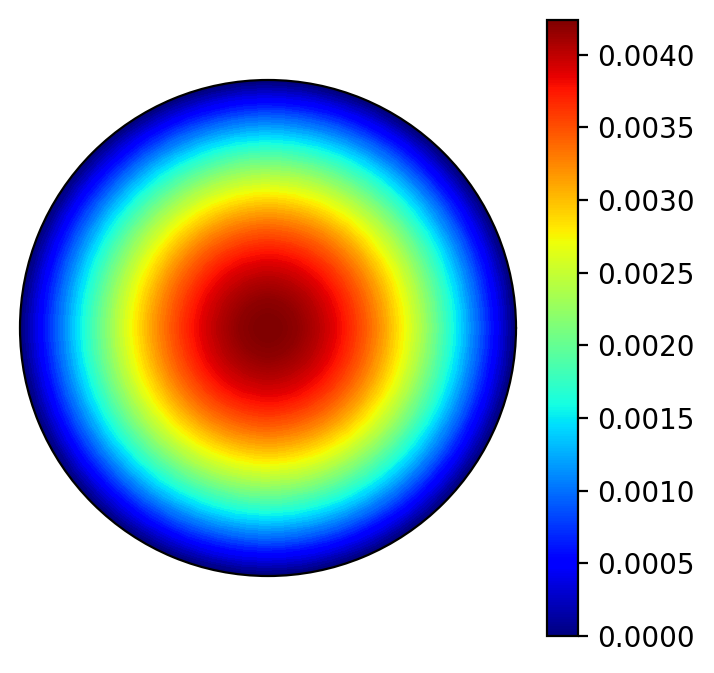

0.004239791644524898


In [ ]:
fig = plt.figure(figsize=(4, 4), dpi=200)
ax = Axes3D(fig)
ax.set_title('With masked values')
rad = np.linspace(0, a, 100)
azm = np.linspace(0, 2 * np.pi, 100)
r, th = np.meshgrid(rad, azm)
z = w(r, D, nu)

plt.subplot(projection="polar")

cs = plt.pcolormesh(th, r, z, cmap='jet')

plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)

plt.grid()
cbar = fig.colorbar(cs)

plt.show()

print(w(0,D, nu))

#Розв'язок за допомогою PINN

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN,self).__init__()
        # def init_weights(m):
        #     if isinstance(m, nn.Linear):
        #         nn.init.xavier_uniform(m.weight)
        #         m.bias.data.fill_(0.02)
        self.net = nn.Sequential(
            nn.Linear(1,64),
            nn.Tanh(),
            # nn.Linear(64,64),
            # nn.Tanh(),
            # nn.Linear(64,64),
            # nn.Tanh(),
            # nn.Linear(64,64),
            # nn.Tanh(),
            # nn.Linear(64,64),
            # nn.Tanh(),
            nn.Linear(64,1)
        )

        # self.apply(init_weights)
        self.double()
    def forward(self,x):
        return self.net(x)

In [ ]:
# x = torch.rand(10, 1, requires_grad = True)
# x

In [ ]:
# x = (0 - 2)*torch.rand(10, 1, requires_grad = True) + 2 + 0.000000000001
# x

In [ ]:
def initial_condition():
    return torch.tensor([0])

def boundary_condition():
    return torch.tensor([0])

In [ ]:
def generate_training_data(num_points, R):
    # x = torch.rand(num_points, 1, requires_grad = True)

    # x_rand = (0 - R)*torch.rand(int(num_points), 1, requires_grad = True) + R + 0.0001

    # x_vals = torch.linspace(0+0.001, R-0.001, num_points, requires_grad = True)
    # x_vals = x_vals + x_rand.flatten()
    # x = torch.stack([x_vals.double()], dim=1)


    # x = (0 - R)*torch.rand(int(num_points), 1, requires_grad = True) + R + 0.0001

    x_vals = torch.linspace(0+0.001, R-0.001, num_points, requires_grad = True)
    x = torch.stack([x_vals.double()], dim=1)


    return x

In [ ]:
tmp = torch.tensor([0.4])
tmp.view(-1,1)

tensor([[0.4000]])

In [ ]:
def generate_boundary_points(b_point):
    x_boundary = torch.tensor([b_point],  requires_grad = True)


    return x_boundary.view(-1,1)


def generate_boundary_training_data(b_point):
    x_boundary = generate_boundary_points(b_point)


    return x_boundary

In [ ]:
def pde(x, model, q, D):

    x = x.double()

    # print('*********************************************************')
    # print(x.size())
    # print(x.dtype)

    input_data = x

    # print('*********************************************************')
    # print(input_data.size())
    # print(input_data.dtype)

    u = model(input_data)
    u_x = torch.autograd.grad(u, x, grad_outputs= torch.ones_like(u), create_graph= True, retain_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs= torch.ones_like(u_x), create_graph= True, retain_graph=True)[0]
    u_xxx = torch.autograd.grad(u_xx, x, grad_outputs= torch.ones_like(u_xx), create_graph= True, retain_graph=True)[0]
    u_xxxx = torch.autograd.grad(u_xxx, x, grad_outputs= torch.ones_like(u_xxx), create_graph= True, retain_graph=True)[0]
    # print('*********************************************************')
    # print(u_x.size())
    # print(u_x.dtype)
    # print('*********************************************************')
    # print(u.size())
    # print(u.dtype)
    # print('*********************************************************')
    # print(x.size())
    # print(x.dtype)

    residual_r = torch.tensor([q/D]).double()

    eq_residual = 1 * (x*x*x) * u_xxxx + 2 * (x*x) * u_xxx - 1 * x * u_xx + 1* u_x
    return eq_residual

In [ ]:
def train_PINN(model, num_iterations, num_points, q, R, D, nu):


    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    # optimizer = optim.SGD(model.parameters(), lr=1e-3)
    # optimizer = optim.LBFGS(model.parameters())
    # breakpoint()
    # x = generate_training_data(num_points, R)
    for  iteration in range(num_iterations):
        optimizer.zero_grad()

        # breakpoint()

        x = generate_training_data(num_points, R)

        # print('generate_training_data')
        # print(x)
        # breakpoint()


        x_b = generate_boundary_training_data(R)

        # print('generate_boundary_training_data')
        # print(x_b)
        # breakpoint()

        x_initial = torch.tensor([0.0],  requires_grad = True)
        x_initial = x_initial.view(-1,1)
        x_initial = x_initial.double()

        # print('x_initial')
        # print(x_initial)
        # breakpoint()

        u_initial_x = initial_condition()
        u_initial_x = u_initial_x.double()

        # print('u_initial_x')
        # print(u_initial_x)
        # breakpoint()


        u_boundary_x = boundary_condition()

        # print('boundary_condition')
        # print(u_boundary_x)
        # breakpoint()

        residual = pde(x, model, q, D)

        # print('residual')
        # print(residual)
        # breakpoint()

        u_boundary_x = u_boundary_x.double()
        x_b = x_b.double()

        ub = model(x_b)
        ui = model(x_initial)

        # print(ub)
        # breakpoint()

        ub_x = torch.autograd.grad(ub, x_b, grad_outputs= torch.ones_like(ub), create_graph= True, retain_graph=True)[0]
        ub_xx = torch.autograd.grad(ub_x, x_b, grad_outputs= torch.ones_like(ub_x), create_graph= True, retain_graph=True)[0]
        ui_x = torch.autograd.grad(ui, x_initial, grad_outputs= torch.ones_like(ui), create_graph= True, retain_graph=True)[0]

        # print('ub_x')
        # print(ub_x)

        # print('ui_x')
        # print(ui_x)

        # print('ub_xx')
        # print(ub_xx)
        # breakpoint()

        residual_r = torch.tensor([q/D]).double() *(x*x*x)

        # print('residual_r')
        # print(residual_r)
        # breakpoint()

        # loss =  nn.MSELoss()(u_boundary_x, ub) + \
        #         nn.MSELoss()(u_boundary_x, ub_x) + \
        #         nn.MSELoss()(u_initial_x, ui_x) + \
        #         nn.MSELoss()(residual, torch.zeros_like(residual))

        loss =  nn.MSELoss()(u_boundary_x, ub) + \
                nn.MSELoss()(u_boundary_x, (x_b)*ub_xx + nu*ub_x) + \
                nn.MSELoss()(u_initial_x, ui_x) + \
                nn.MSELoss()(residual, residual_r)

        # loss =  nn.MSELoss()(u_boundary_x, ub) + \
        #         nn.MSELoss()(u_boundary_x, ub_x) + \
        #         nn.MSELoss()(u_boundary_x, ub_xx) + \
        #         nn.MSELoss()(u_initial_x, ui_x) + \
        #         nn.MSELoss()(residual, residual_r)



        # l1_regularization, l2_regularization = torch.tensor(0.0), torch.tensor(0.0)
        # for param in model.parameters():
        #     l1_regularization += torch.norm(param, 1)**2
        #     l2_regularization += torch.norm(param, 2)**2

        # loss = loss + l1_regularization + l2_regularization

        # print('loss')
        # print(loss)
        # breakpoint()

        loss.backward()

        # breakpoint()

        optimizer.step()

        # breakpoint()

        if iteration % 100 == 0:
            print("itration", iteration, "loss", loss )

In [ ]:
a

0.4

In [ ]:
model = PINN()
num_iterations = 20000
num_points = 100
train_PINN(model, num_iterations, num_points, q, a, D, nu)

itration 0 loss tensor(0.1899, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning:

Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



itration 100 loss tensor(0.0229, dtype=torch.float64, grad_fn=<AddBackward0>)
itration 200 loss tensor(0.0062, dtype=torch.float64, grad_fn=<AddBackward0>)
itration 300 loss tensor(0.0054, dtype=torch.float64, grad_fn=<AddBackward0>)
itration 400 loss tensor(0.0050, dtype=torch.float64, grad_fn=<AddBackward0>)
itration 500 loss tensor(0.0047, dtype=torch.float64, grad_fn=<AddBackward0>)
itration 600 loss tensor(0.0044, dtype=torch.float64, grad_fn=<AddBackward0>)
itration 700 loss tensor(0.0041, dtype=torch.float64, grad_fn=<AddBackward0>)
itration 800 loss tensor(0.0039, dtype=torch.float64, grad_fn=<AddBackward0>)
itration 900 loss tensor(0.0038, dtype=torch.float64, grad_fn=<AddBackward0>)
itration 1000 loss tensor(0.0036, dtype=torch.float64, grad_fn=<AddBackward0>)
itration 1100 loss tensor(0.0034, dtype=torch.float64, grad_fn=<AddBackward0>)
itration 1200 loss tensor(0.0033, dtype=torch.float64, grad_fn=<AddBackward0>)
itration 1300 loss tensor(0.0032, dtype=torch.float64, grad_f

In [ ]:
with torch.no_grad():
    x_vals = torch.linspace(0, a-0.00001, 50)


    input_data = torch.stack([x_vals.double()], dim=1)
    solution = model(input_data)
    sol = torch.stack([x_vals, solution.flatten()], dim=1)

    print(sol)



tensor([[0.0000e+00, 4.3336e-03],
        [8.1631e-03, 4.3317e-03],
        [1.6326e-02, 4.3252e-03],
        [2.4489e-02, 4.3141e-03],
        [3.2652e-02, 4.2983e-03],
        [4.0815e-02, 4.2780e-03],
        [4.8978e-02, 4.2532e-03],
        [5.7141e-02, 4.2239e-03],
        [6.5304e-02, 4.1902e-03],
        [7.3468e-02, 4.1521e-03],
        [8.1631e-02, 4.1096e-03],
        [8.9794e-02, 4.0629e-03],
        [9.7957e-02, 4.0119e-03],
        [1.0612e-01, 3.9568e-03],
        [1.1428e-01, 3.8976e-03],
        [1.2245e-01, 3.8344e-03],
        [1.3061e-01, 3.7672e-03],
        [1.3877e-01, 3.6961e-03],
        [1.4694e-01, 3.6212e-03],
        [1.5510e-01, 3.5425e-03],
        [1.6326e-01, 3.4603e-03],
        [1.7142e-01, 3.3745e-03],
        [1.7959e-01, 3.2852e-03],
        [1.8775e-01, 3.1925e-03],
        [1.9591e-01, 3.0966e-03],
        [2.0408e-01, 2.9975e-03],
        [2.1224e-01, 2.8954e-03],
        [2.2040e-01, 2.7903e-03],
        [2.2857e-01, 2.6824e-03],
        [2.367

In [ ]:
sol_np = sol.numpy()
np.shape(sol_np)
points = sol_np[:, 0]
points

array([0.        , 0.00816306, 0.01632612, 0.02448918, 0.03265224,
       0.0408153 , 0.04897837, 0.05714143, 0.06530449, 0.07346755,
       0.08163061, 0.08979367, 0.09795673, 0.1061198 , 0.11428285,
       0.12244591, 0.13060898, 0.13877204, 0.14693511, 0.15509816,
       0.16326122, 0.17142428, 0.17958733, 0.1877504 , 0.19591346,
       0.20407653, 0.21223959, 0.22040266, 0.22856571, 0.23672877,
       0.24489184, 0.25305489, 0.26121795, 0.26938102, 0.27754408,
       0.28570715, 0.29387021, 0.30203325, 0.31019631, 0.31835938,
       0.32652244, 0.3346855 , 0.34284857, 0.35101163, 0.3591747 ,
       0.36733776, 0.3755008 , 0.38366386, 0.39182693, 0.39998999])

In [ ]:
pred_y = []
true_y = []
pred_y = sol_np[:, 1]
for x in points:
    true_y.append(w(x, D, nu))

print(true_y)

[0.004239791644524898, 0.0042375929593241315, 0.004230999068260974, 0.004220016464952858, 0.004204655972095501, 0.004184932741462908, 0.004160866253907372, 0.004132480319359473, 0.004099803076828078, 0.004062866976577861, 0.0040217088692417035, 0.003976369849234047, 0.003926895324784932, 0.0038733351198422194, 0.003815743402347041, 0.0037541785677484923, 0.0036887033260699035, 0.0036193848325030724, 0.003546294516938519, 0.003469508281847043, 0.003389105934828368, 0.0033051720298426196, 0.0032177954757042137, 0.003127069028579789, 0.003033090249247235, 0.002935960871184595, 0.0028357869569561028, 0.0027326788982121805, 0.002626751611554953, 0.0025181237598942688, 0.002406918912957391, 0.0022932649883558947, 0.002177293608021504, 0.0020591413433784476, 0.0019389488896646714, 0.001816861271204311, 0.001693027841407692, 0.001567602743399611, 0.0014407430724482843, 0.001312611624308226, 0.0011833750687187158, 0.001053204404505222, 0.0009222749595794041, 0.0007907663909391107, 0.00065886268

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import plot

def plot_feature(true_y, pred_y, points):

    fig_prices = go.Figure()
    fig_prices.add_trace(go.Scatter(x=points, y=true_y,
                        # fill= 'tonexty',
                        mode='lines',
                        # line_color='indigo',
                        name="Точний розв'язок"))
    fig_prices.add_trace(go.Scatter(
                        x=points,
                        y=pred_y,
                        # fill='tonexty', # fill area between trace0 and trace1
                        mode='lines',
                        # line_color='red',
                        name="Наближений розв'язок"))


    fig_prices.update_layout(yaxis_title="Значення функції")
    fig_prices.update_layout(
    xaxis=dict(
        title='Точки колокації',
        title_font=dict(size=20),  # Збільшення розміру шрифту підпису осі X
        tickfont=dict(size=16),    # Збільшення розміру шрифту тікерів
    ),
    yaxis=dict(
        title='Значення функції',
        title_font=dict(size=20),  # Збільшення розміру шрифту підпису осі Y
        tickfont=dict(size=16),    # Збільшення розміру шрифту тікерів
    ),
    legend=dict(
        font=dict(size=18)          # Збільшення розміру шрифту легенди
    )
)
    fig_prices.show()

    return 0

In [ ]:
plot_feature(true_y, pred_y, points)

0

In [ ]:
import pandas as pd
import numpy as np

# Об'єднання масивів в DataFrame та назви стовпців
df = pd.DataFrame({'True': true_y, 'Pred': np.round(pred_y, 6)})

# Вивід DataFrame
print(df)

            True      Pred
0   4.239792e-03  0.004334
1   4.237593e-03  0.004332
2   4.230999e-03  0.004325
3   4.220016e-03  0.004314
4   4.204656e-03  0.004298
5   4.184933e-03  0.004278
6   4.160866e-03  0.004253
7   4.132480e-03  0.004224
8   4.099803e-03  0.004190
9   4.062867e-03  0.004152
10  4.021709e-03  0.004110
11  3.976370e-03  0.004063
12  3.926895e-03  0.004012
13  3.873335e-03  0.003957
14  3.815743e-03  0.003898
15  3.754179e-03  0.003834
16  3.688703e-03  0.003767
17  3.619385e-03  0.003696
18  3.546295e-03  0.003621
19  3.469508e-03  0.003543
20  3.389106e-03  0.003460
21  3.305172e-03  0.003374
22  3.217795e-03  0.003285
23  3.127069e-03  0.003193
24  3.033090e-03  0.003097
25  2.935961e-03  0.002998
26  2.835787e-03  0.002895
27  2.732679e-03  0.002790
28  2.626752e-03  0.002682
29  2.518124e-03  0.002572
30  2.406919e-03  0.002459
31  2.293265e-03  0.002343
32  2.177294e-03  0.002225
33  2.059141e-03  0.002105
34  1.938949e-03  0.001983
35  1.816861e-03  0.001859
3

In [ ]:
np.round(pred_y, 6)

array([4.334e-03, 4.332e-03, 4.325e-03, 4.314e-03, 4.298e-03, 4.278e-03,
       4.253e-03, 4.224e-03, 4.190e-03, 4.152e-03, 4.110e-03, 4.063e-03,
       4.012e-03, 3.957e-03, 3.898e-03, 3.834e-03, 3.767e-03, 3.696e-03,
       3.621e-03, 3.543e-03, 3.460e-03, 3.374e-03, 3.285e-03, 3.193e-03,
       3.097e-03, 2.998e-03, 2.895e-03, 2.790e-03, 2.682e-03, 2.572e-03,
       2.459e-03, 2.343e-03, 2.225e-03, 2.105e-03, 1.983e-03, 1.859e-03,
       1.733e-03, 1.605e-03, 1.476e-03, 1.346e-03, 1.215e-03, 1.083e-03,
       9.500e-04, 8.160e-04, 6.820e-04, 5.480e-04, 4.140e-04, 2.800e-04,
       1.470e-04, 1.400e-05])

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

mean_absolute_percentage_error([true_y[0]], [pred_y[0]])

0.02211648679799718

In [ ]:
pred_y

array([4.33356094e-03, 4.33171455e-03, 4.32520424e-03, 4.31406192e-03,
       4.29832206e-03, 4.27802172e-03, 4.25320064e-03, 4.22390132e-03,
       4.19016909e-03, 4.15205214e-03, 4.10960173e-03, 4.06287203e-03,
       4.01192035e-03, 3.95680725e-03, 3.89759653e-03, 3.83435525e-03,
       3.76715382e-03, 3.69606622e-03, 3.62116989e-03, 3.54254603e-03,
       3.46027901e-03, 3.37445738e-03, 3.28517345e-03, 3.19252289e-03,
       3.09660572e-03, 2.99752576e-03, 2.89539079e-03, 2.79031265e-03,
       2.68240746e-03, 2.57179488e-03, 2.45859934e-03, 2.34294947e-03,
       2.22497755e-03, 2.10482073e-03, 1.98262030e-03, 1.85852186e-03,
       1.73267538e-03, 1.60523567e-03, 1.47636051e-03, 1.34621352e-03,
       1.21496222e-03, 1.08277858e-03, 9.49838933e-04, 8.16324054e-04,
       6.82419086e-04, 5.48313553e-04, 4.14201819e-04, 2.80281109e-04,
       1.46754414e-04, 1.38284958e-05])

In [ ]:
len(points)

50

In [ ]:
len(pred_y)

50

In [ ]:
np.shape(z)

(100, 100)

In [ ]:
def transform_to_matrix(input_array):
    n = len(input_array)
    reshaped_matrix = np.array([np.repeat(value, n) for value in input_array])
    return reshaped_matrix

z = pred_y
result_matrix = transform_to_matrix(z)

print("Оригінальний масив:", z)
print("Масив розмірності (n, n) з векторами та повторюваними значеннями:", result_matrix)


Оригінальний масив: [4.33356094e-03 4.33171455e-03 4.32520424e-03 4.31406192e-03
 4.29832206e-03 4.27802172e-03 4.25320064e-03 4.22390132e-03
 4.19016909e-03 4.15205214e-03 4.10960173e-03 4.06287203e-03
 4.01192035e-03 3.95680725e-03 3.89759653e-03 3.83435525e-03
 3.76715382e-03 3.69606622e-03 3.62116989e-03 3.54254603e-03
 3.46027901e-03 3.37445738e-03 3.28517345e-03 3.19252289e-03
 3.09660572e-03 2.99752576e-03 2.89539079e-03 2.79031265e-03
 2.68240746e-03 2.57179488e-03 2.45859934e-03 2.34294947e-03
 2.22497755e-03 2.10482073e-03 1.98262030e-03 1.85852186e-03
 1.73267538e-03 1.60523567e-03 1.47636051e-03 1.34621352e-03
 1.21496222e-03 1.08277858e-03 9.49838933e-04 8.16324054e-04
 6.82419086e-04 5.48313553e-04 4.14201819e-04 2.80281109e-04
 1.46754414e-04 1.38284958e-05]
Масив розмірності (n, n) з векторами та повторюваними значеннями: [[4.33356094e-03 4.33356094e-03 4.33356094e-03 ... 4.33356094e-03
  4.33356094e-03 4.33356094e-03]
 [4.33171455e-03 4.33171455e-03 4.33171455e-03 ... 

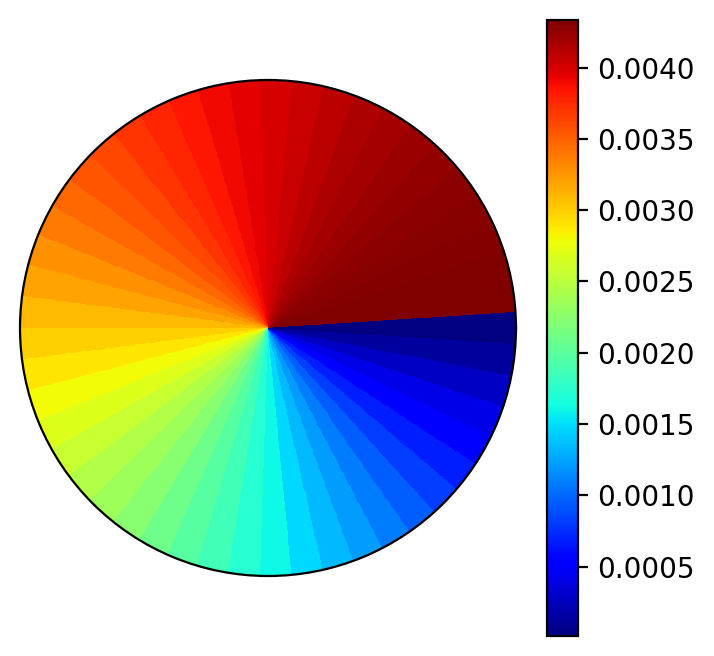

In [ ]:
fig = plt.figure(figsize=(4, 4), dpi=200)
ax = Axes3D(fig)
ax.set_title('With masked values')
rad = points
azm = np.linspace(0, 2 * np.pi, len(points))
r, th = np.meshgrid(rad, azm)
z = result_matrix

plt.subplot(projection="polar")

cs = plt.pcolormesh(th, r, z, cmap='jet')

plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)

plt.grid()
cbar = fig.colorbar(cs)

plt.show()


In [ ]:
import numpy as np

def transform_to_matrix(input_array):
    """
    Функція, що перетворює одновимірний масив в масив розмірності (n, n) з повторюваними значеннями.

    Параметри:
    - input_array: Одновимірний масив розмірності n.

    Повертає:
    - Масив розмірності (n, n) з повторюваними значеннями.
    """
    n = len(input_array)
    reshaped_matrix = np.array([input_array] * n)
    return reshaped_matrix

# Приклад використання
original_array = [1, 2, 3, 4, 5]
result_matrix = transform_to_matrix(original_array)

print("Оригінальний масив:", original_array)
print("Масив розмірності (n, n) з повторюваними значеннями:", result_matrix)


Оригінальний масив: [1, 2, 3, 4, 5]
Масив розмірності (n, n) з повторюваними значеннями: [[1 2 3 4 5]
 [1 2 3 4 5]
 [1 2 3 4 5]
 [1 2 3 4 5]
 [1 2 3 4 5]]


In [ ]:
import numpy as np

def transform_to_matrix(input_array):
    """
    Функція, що перетворює одновимірний масив в масив розмірності (n, n),
    де на кожній позиції старого масива записано вектор з повторюваним значенням відповідного значення початкового масиву.

    Параметри:
    - input_array: Одновимірний масив розмірності n.

    Повертає:
    - Масив розмірності (n, n) з векторами, де значення векторів повторюються відповідно до значень вхідного масиву.
    """
    n = len(input_array)
    reshaped_matrix = np.array([np.repeat(value, n) for value in input_array])
    return reshaped_matrix

# Приклад використання
original_array = [1, 2, 3, 4, 5]
result_matrix = transform_to_matrix(original_array)

print("Оригінальний масив:", original_array)
print("Масив розмірності (n, n) з векторами та повторюваними значеннями:", result_matrix)


Оригінальний масив: [1, 2, 3, 4, 5]
Масив розмірності (n, n) з векторами та повторюваними значеннями: [[1 1 1 1 1]
 [2 2 2 2 2]
 [3 3 3 3 3]
 [4 4 4 4 4]
 [5 5 5 5 5]]
